<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">


# Web Scraping for Indeed.com and Predicting Salaries

### Business Case Overview

You're working as a data scientist for a contracting firm that's rapidly expanding. Now that they have their most valuable employee (you!), they need to leverage data to win more contracts. Your firm offers technology and scientific solutions and wants to be competitive in the hiring market. Your principal wants you to

   - determine the industry factors that are most important in predicting the salary amounts for these data.

To limit the scope, your principal has suggested that you *focus on data-related job postings*, e.g. data scientist, data analyst, research scientist, business intelligence, and any others you might think of. You may also want to decrease the scope by *limiting your search to a single region.*

Hint: Aggregators like [Indeed.com](https://www.indeed.com) regularly pool job postings from a variety of markets and industries.

**Goal:** Scrape your own data from a job aggregation tool like Indeed.com in order to collect the data to best answer this question.

---

### Directions

In this project you will be leveraging a variety of skills. The first will be to use the web-scraping and/or API techniques you've learned to collect data on data jobs from Indeed.com or another aggregator. Once you have collected and cleaned the data, you will use it to address the question above.

### Factors that impact salary

To predict salary the most appropriate approach would be a regression model.
Here instead we just want to estimate which factors (like location, job title, job level, industry sector) lead to high or low salary and work with a classification model. To do so, split the salary into two groups of high and low salary, for example by choosing the median salary as a threshold (in principle you could choose any single or multiple splitting points).

Use all the skills you have learned so far to build a predictive model.
Whatever you decide to use, the most important thing is to justify your choices and interpret your results. *Communication of your process is key.* Note that most listings **DO NOT** come with salary information. You'll need to be able to extrapolate or predict the expected salaries for these listings.

### Load in the the data of scraped salaries

In [2]:
## YOUR CODE HERE
df = pd.read_csv('web scrapes/final_data.csv')

In [3]:
df.drop(columns='Unnamed: 0', axis=1, inplace=True)

In [4]:
## Find Baseline accuracy
df.sal_hilo.value_counts(normalize=True)

low     0.500276
high    0.499724
Name: sal_hilo, dtype: float64

### Create a classification model to predict High/Low salary. 


- Start by ONLY using the location as a feature.
- Use at least two different classifiers you find suitable.
- Remember that scaling your features might be necessary.
- Display the coefficients/feature importances and write a short summary of what they mean.
- Create a few new variables in your dataframe to represent interesting features of a job title (e.g. whether 'Senior' or 'Manager' is in the title).
- Incorporate other text features from the title or summary that you believe will predict the salary.
- Then build new classification models including also those features. Do they add any value?
- Tune your models by testing parameter ranges, regularization strengths, etc. Discuss how that affects your models.
- Discuss model coefficients or feature importances as applicable.

In [5]:
#find cities that only occur once
df[df.groupby('City')['City'].transform('size') == 1 ]

,title,company,City,State,rate,salary_avg,sal_hilo
162,SALES ANALYST,Planterra Foods,Lafayette,CO,year,60000.0,low
242,Business Analyst,NIM Group,Brighton,CO,year,63000.0,low
249,Supply Chain Analyst,SRP Companies,Castle Rock,CO,year,95000.0,high
263,Business Analyst,Chuck Latham Associates,Parker,CO,year,65000.0,low
304,Data Analyst Consultant,C.H Robinson,Wood Dale,IL,year,73375.0,low
...,...,...,...,...,...,...,...
1757,PUBLIC UTILITIES REGULATORY ANALYST V,California Public Utilities Commission,San Francisco County,CA,month,116166.0,high
1795,Software Engineer Advisor - Machine Learning,FedEx Services,Chalfont,PA,month,130944.0,high
1802,Crime Analyst Administrator,City of Frisco,Frisco,TX,month,71664.0,low
1803,HR Analyst,"City of Allen, TX",Allen,TX,month,52440.0,low


- Since 176 cities only appeared once, decided to create a subset with these cities removed for the modelling

In [6]:
df_cities = df[df.groupby('City')['City'].transform('size') > 1 ]

#dumified predictor location variables: city and state 
df_cities = pd.get_dummies(df_cities, columns=['City', 'State'], drop_first=True)

In [7]:
#create target variable
y = df_cities.pop('sal_hilo')

In [8]:
#baseline accuracy for our model 
y.value_counts(normalize=True)

high    0.510703
low     0.489297
Name: sal_hilo, dtype: float64

- based on the baseline accuracy, I am aiming for a score > 0.51

In [9]:
#removed other variables that were not relevant 
a = df_cities.pop('title')
b = df_cities.pop('company')
d = df_cities.pop('rate')
d = df_cities.pop('salary_avg')

In [10]:
#create predictor variables 
X = df_cities

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score

#### Model 1 = Logistic regression using only location variables :

In [12]:
log = LogisticRegression()
sc = StandardScaler()
kf = StratifiedKFold(n_splits=5)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,test_size=0.2, random_state=42)

In [14]:
X_train = pd.DataFrame(sc.fit_transform(X_train),
                       columns=X_train.columns)
X_test = pd.DataFrame(sc.transform(X_test),
                     columns = X_test.columns)

In [15]:
log.fit(X_train, y_train)
print('train score:',log.score(X_train, y_train))
print('test score:',log.score(X_test, y_test))
print('mean of cross-val score:',cross_val_score(log, X_train, y_train, cv=kf).mean())

train score: 0.6636085626911316
test score: 0.6116207951070336
mean of cross-val score: 0.5779795852709777


In [16]:
# used Grid search to tune the model 
log_params = {'penalty': ['l1', 'l2'],
                   'solver': ['liblinear'],
                   'C': np.logspace(-4, 4, 9)}
gs = GridSearchCV(log, log_params, cv=kf, n_jobs=2, verbose=1)

In [17]:
gs.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/Applications/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(), n_jobs=2,
             param_grid={'C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
       1.e+04]),
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             verbose=1)

In [18]:
print('best parameters:',gs.best_params_)
print('best score:',gs.best_score_)
best_logreg = gs.best_estimator_
print('train score:',best_logreg.score(X_train, y_train))
print('test score:',best_logreg.score(X_test, y_test))

best parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
best score: 0.5932760083062794
train score: 0.6490825688073395
test score: 0.5871559633027523


- Applying a logistic regression to the predict a high or low salary using the scaled, location features of City and State gave a cross-validation of score 0.57
- Tuning the model to find the optimal hyperparameters improved the score to 0.593
- Therefore the model's accurately classifying 59% of the low and high classes
 - Accuracy = (true lows + true highs)/total lows+highs

In [19]:
#create df of top 10 postive and negative coefficients 
feat_1 =pd.DataFrame(list(zip(X.columns, log.coef_[0])), columns=['feature', 'coef']).sort_values(by='coef')[:10]
feat_2 =pd.DataFrame(list(zip(X.columns, log.coef_[0])), columns=['feature', 'coef']).sort_values(by='coef')[151:161]
feat_im = pd.concat([feat_1.reset_index(drop=True), feat_2.reset_index(drop=True)], axis=0)

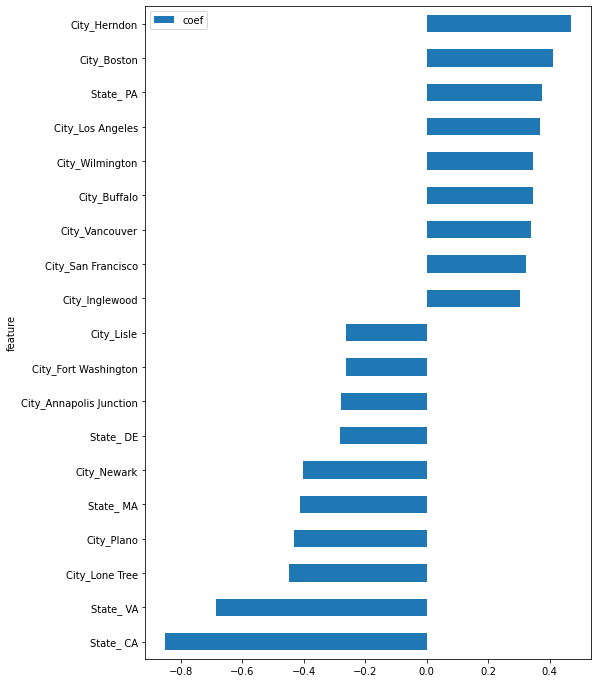

In [20]:
#The positive scores indicate a feature that predicts class =low, 
#whereas the negative scores indicate a feature that predicts class =high
feat_im.plot(kind='barh', x='feature', y='coef', figsize=(8, 12))
plt.show()

 
- The above bar chart shows the top 10 coefficients that are the strongest predictors for the low and high salary classes: 
  - the positive scores indicate a feature that predicts 'low':
      - The cities of Herndon and Boston and state of PA are the strongest for the low class
  - the negative scores indicate a feature that predicts 'high':
      - The state of CA and VA and city of lone tree are strongest for the high class

#### Model 2 = Decision Tree using only location variables :

In [21]:
classifier = DecisionTreeClassifier(criterion='gini',
                                    max_depth=2, 
                                    random_state=1)
classifier.fit(X_train, y_train)
print('train score:',classifier.score(X_train, y_train))
print('test score:',classifier.score(X_test, y_test))
print('cross val score:',cross_val_score(classifier, X_train, y_train, cv=kf).mean())

train score: 0.5535168195718655
test score: 0.5504587155963303
cross val score: 0.5229066128513351


In [22]:
# tune with gridsearch 

tree_params = {
    'max_depth': list(range(1, 11))+[None],
    'max_features': [None, 1, 2, 3,4,5,6],
    'min_samples_split': [2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50],
    'ccp_alpha': [0, 0.001, 0.005, 0.01]
}
tree_gs = GridSearchCV(classifier, tree_params, cv=kf, n_jobs=2, verbose=1)
tree_gs.fit(X_train, y_train)

Fitting 5 folds for each of 3388 candidates, totalling 16940 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(max_depth=2, random_state=1),
             n_jobs=2,
             param_grid={'ccp_alpha': [0, 0.001, 0.005, 0.01],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None],
                         'max_features': [None, 1, 2, 3, 4, 5, 6],
                         'min_samples_split': [2, 3, 4, 5, 10, 15, 20, 25, 30,
                                               40, 50]},
             verbose=1)

In [23]:
print('best parameters:',tree_gs.best_params_)
print('best cv score:', tree_gs.best_score_)
best_tree = tree_gs.best_estimator_
print('train score:',best_tree.score(X_train, y_train))
print('test score:',best_tree.score(X_test, y_test))

best parameters: {'ccp_alpha': 0, 'max_depth': None, 'max_features': 5, 'min_samples_split': 20}
best cv score: 0.5917258927788015
train score: 0.6536697247706422
test score: 0.617737003058104


- Applying a decision tree classifier gave a cross-validation of score 0.523
- Tuning the model to find the optimal hyperparameters improved the score to 0.592
    - Therefore the model's accurately predicting 59% of the low and high classes
- The logistic regression model's score is only slightly higher (0.593)

In [24]:
fi = pd.DataFrame({
    'feature': X.columns,
    'importance': best_tree.feature_importances_
})

fi.sort_values('importance', ascending=False, inplace=True)
fi[:20]

,feature,importance
154,State_ NY,0.055686
70,City_Lone Tree,0.036664
10,City_Austin,0.036149
112,City_San Francisco,0.029979
99,City_Plano,0.028951
97,City_Phoenix,0.027408
130,City_Vancouver,0.025466
86,City_Newark,0.025233
39,City_Englewood,0.025027
137,City_Westminster,0.023077


- The above df lists the top 20 features that had the highest impact in predicting the high or low class when applying the decision tree model
- The State_NY was most important in the branching of the decision tree model, followed by City_Lone Tree and City_Austin

#### Incorporating terms used in job title column 

In [25]:
#starting with same subset as above
df_2 = df[df.groupby('City')['City'].transform('size') > 1 ]
df_2 = pd.get_dummies(df_2, columns=['City', 'State'], drop_first=True)

In [26]:
df_2.shape

(1635, 165)

In [27]:
import nltk

In [28]:
from sklearn.feature_extraction.text import CountVectorizer

cvec = CountVectorizer(stop_words='english', ngram_range=(1, 1), max_features=3000)

In [29]:
cvec.fit(df_2['title'])
tdata = cvec.transform(df_2['title'])

In [30]:
dft = pd.DataFrame(tdata.toarray(),columns=cvec.get_feature_names())
dft

,00017790,00018690,00019926,0142,0161,017,023,02602,0319,0635,...,window,wms,wms2,work,workday,worker,workforce,working,writer,years
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1630,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1631,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1632,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1633,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
#show top 20 terms 
a = tdata.sum(axis=0)
pd.DataFrame(a, columns=cvec.get_feature_names()).transpose().sort_values(by=0, ascending=False)[:20]

,0
analyst,1130
data,792
business,463
senior,265
scientist,253
engineer,120
learning,98
machine,88
sr,82
remote,75


In [32]:
df_feat = dft[['analyst', 'business', 'senior', 'scientist', 'machine', 'sr', 'engineer']]

- Decided to use the above terms as I thought they would have the biggest impacts for predicting high or low salary
- Chose machine instead of learning as they were mostly used together and machine was higher
- Did not include the term data as all jobs were data based

In [33]:
#merged df with df_2
X = pd.concat([df_2.reset_index(drop=True),df_feat.reset_index(drop=True)], axis=1)

In [34]:
y = X.pop('sal_hilo')

In [35]:
X.head()

,title,company,rate,salary_avg,City_Albany,City_Alexandria,City_Allegheny County,City_Alpharetta,City_Anaheim,City_Annapolis Junction,...,State_ TX,State_ VA,State_ WA,analyst,business,senior,scientist,machine,sr,engineer
0,Data Scientist,Oracle,year,139064.0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,Data Scientist - Nationwide Opportunities,"Amazon Web Services, Inc.",year,139650.0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,Senior Data Scientist,Verizon,year,167000.0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
3,Principal Data Scientist,Verizon,year,157000.0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,Data Scientist,Appcast Inc.,year,80000.0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [36]:
a = X.pop('title')
b = X.pop('company')
d = X.pop('rate')
d = X.pop('salary_avg')

#### Model 1: Logistic Regression with location and job title terms:

In [37]:
log = LogisticRegression()
sc = StandardScaler()
kf = StratifiedKFold(n_splits=5)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
X_train = pd.DataFrame(sc.fit_transform(X_train),
                       columns=X_train.columns)
X_test = pd.DataFrame(sc.transform(X_test),
                     columns = X_test.columns)

In [40]:
log.fit(X_train, y_train)
print('train score:',log.score(X_train, y_train))
print('test score:',log.score(X_test, y_test))
print('mean of cross-val score:',cross_val_score(log, X_train, y_train, cv=kf).mean())

train score: 0.7660550458715596
test score: 0.7431192660550459
mean of cross-val score: 0.6903600362668538


In [41]:
#tuning with grid search:
log_params = {'penalty': ['l1', 'l2'],
                   'solver': ['liblinear'],
                   'C': np.logspace(-4, 4, 9)}
gs = GridSearchCV(log, log_params, cv=kf, n_jobs=2, verbose=1)

In [42]:
gs.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(), n_jobs=2,
             param_grid={'C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
       1.e+04]),
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             verbose=1)

In [43]:
print('best parameters:',gs.best_params_)
print('best score:',gs.best_score_)
best_logreg = gs.best_estimator_
print('train score:',best_logreg.score(X_train, y_train))
print('test score:',best_logreg.score(X_test, y_test))

best parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
best score: 0.704907724254921
train score: 0.764525993883792
test score: 0.746177370030581


In [46]:
log_2 = LogisticRegression(C=0.1,
                            penalty='l1',
                              solver='liblinear')

log_bag = BaggingClassifier(base_estimator=log_2,
                            max_samples=.6, 
                            max_features=.95, 
                            n_estimators=100)

print("log Bagging CV training score:\t", 
      cross_val_score(log_bag, X_train, y_train,
                    cv=kf, n_jobs=-2).mean())

log_bag.fit(X_train, y_train)
print("log bagging training score:\t", log_bag.score(X_train, y_train))
print("log bagging test score:\t", log_bag.score(X_test, y_test))

log Bagging CV training score:	 0.70795238513059
log bagging training score:	 0.7553516819571865
log bagging test score:	 0.7553516819571865


In [47]:
#grid search to tune the bagging classifier
model = BaggingClassifier(base_estimator=log_2, n_estimators=100)
params = {'max_samples': np.linspace(0.8, 1.0, 3),
          'max_features': range(int(3/4.*X.shape[1]), X.shape[1]+1)}

log_bag_grid = GridSearchCV(model, param_grid=params, cv=5, n_jobs=-2)
log_bag_grid.fit(X_train, y_train)
log_bag_grid.best_estimator_

BaggingClassifier(base_estimator=LogisticRegression(C=0.1, penalty='l1',
                                                    solver='liblinear'),
                  max_features=135, max_samples=0.8, n_estimators=100)

In [49]:
print('train score:',log_bag_grid.score(X_train, y_train))
print('test score:',log_bag_grid.score(X_test, y_test))
print('best cv score:',log_bag_grid.best_score_)

train score: 0.7584097859327217
test score: 0.7553516819571865
best cv score: 0.7186598812553011


In [52]:
log_bag = BaggingClassifier(base_estimator=log_2, n_estimators=100,
                           max_features=135, max_samples=0.8)

log_bag.fit(X_train, y_train)

BaggingClassifier(base_estimator=LogisticRegression(C=0.1, penalty='l1',
                                                    solver='liblinear'),
                  max_features=135, max_samples=0.8, n_estimators=100)

- Applying a logistic regression with the lcoation and title terms gave a cross-validation score of 0.690
- Tuning the model with the grid search improved the score to 0.705, which was further improved by adding a bagging classifier to 0.708 and finally after using grid search again to tune the bagging classifier the score was 0.719

In [53]:
feat_1 =pd.DataFrame(list(zip(X.columns, log.coef_[0])), columns=['feature', 'coef']).sort_values(by='coef')[157:168]
feat_2 =pd.DataFrame(list(zip(X.columns, log.coef_[0])), columns=['feature', 'coef']).sort_values(by='coef')[:10]
feat_im = pd.concat([feat_1.reset_index(drop=True), feat_2.reset_index(drop=True)], axis=0)

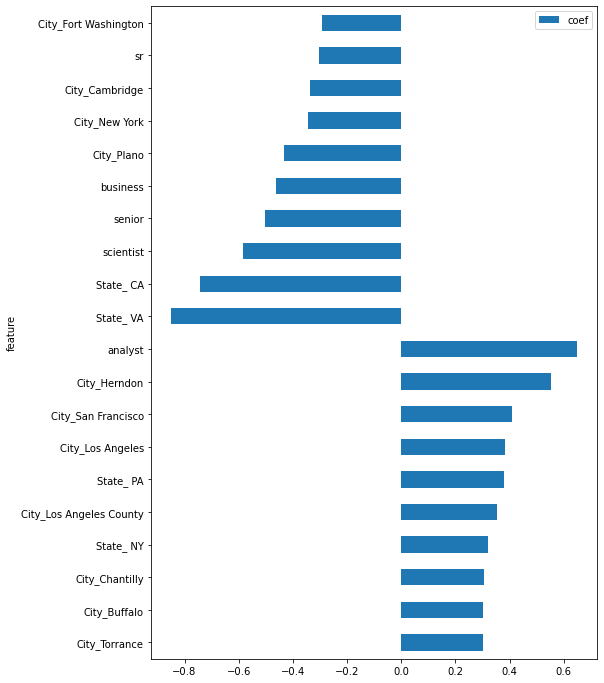

In [54]:
#The positive scores indicate a feature that predicts class =low, 
#whereas the negative scores indicate a feature that predicts class  =high
feat_im.plot(kind='barh', x='feature', y='coef', figsize=(8, 12))
plt.show()

- The strongest coefficients predicting a low class were 'analyst', the cities of Herndon, San Francisco and Los Angeles
- The strongest coefs predicting a high class were the states of VA and CA, and the terms scientist, senior and business
- This indicates the terms analyst and scientist are more often associated with a low and high salary, respectively. This is interesting as more data analyst roles are becoming basically the same as a data scientist, however companies can offer lower pay for similar work 

#### Model 2: Decision Tree with location and job title terms:

In [55]:
classifier = DecisionTreeClassifier(criterion='gini',
                                    max_depth=2, 
                                    random_state=1)
classifier.fit(X_train, y_train)
print('train score:',classifier.score(X_train, y_train))
print('test score:', classifier.score(X_test, y_test))
print('cross val score:',cross_val_score(classifier, X_train, y_train, cv=kf).mean())

train score: 0.6819571865443425
test score: 0.7339449541284404
cross val score: 0.658997981925068


In [56]:
#tune with grid search 
tree_params = {
    'max_depth': list(range(1, 11))+[None],
    'max_features': [None, 1, 2, 3,4,5,6],
    'min_samples_split': [2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50],
    'ccp_alpha': [0, 0.001, 0.005, 0.01]
}
tree_gs = GridSearchCV(classifier, tree_params, cv=kf, n_jobs=2, verbose=1)
tree_gs.fit(X_train, y_train)

Fitting 5 folds for each of 3388 candidates, totalling 16940 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(max_depth=2, random_state=1),
             n_jobs=2,
             param_grid={'ccp_alpha': [0, 0.001, 0.005, 0.01],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None],
                         'max_features': [None, 1, 2, 3, 4, 5, 6],
                         'min_samples_split': [2, 3, 4, 5, 10, 15, 20, 25, 30,
                                               40, 50]},
             verbose=1)

In [57]:
print('best parameters:',tree_gs.best_params_)
print('best cv score:',tree_gs.best_score_)
best_tree = tree_gs.best_estimator_
print('train score:',best_tree.score(X_train, y_train))
print('test score:',best_tree.score(X_test, y_test))

best parameters: {'ccp_alpha': 0, 'max_depth': None, 'max_features': None, 'min_samples_split': 15}
best cv score: 0.7110204439764851
train score: 0.8402140672782875
test score: 0.7125382262996942


In [59]:
#adding a bagging classifier :
tree = DecisionTreeClassifier(criterion='gini',
                            max_depth=None,
                              max_features=None,
                              min_samples_split= 15,
                              ccp_alpha = 0,
                              random_state=42)

tree_bag = BaggingClassifier(base_estimator=tree,
                            max_samples=.6, 
                            max_features=.95, 
                            n_estimators=100)

print("Tree Bagging CV training score:\t", 
      cross_val_score(tree_bag, X_train, y_train,
                    cv=kf, n_jobs=-2).mean())

tree_bag.fit(X_train, y_train)
print("Tree bagging training score:\t", tree_bag.score(X_train, y_train))
print("Tree bagging test score:\t", tree_bag.score(X_test, y_test))

Tree Bagging CV training score:	 0.712547161533737
Tree bagging training score:	 0.8042813455657493
Tree bagging test score:	 0.709480122324159


In [60]:
# using grid search on bagging classifier:
model = BaggingClassifier(base_estimator=tree, n_estimators=100)
params = {'max_samples': np.linspace(0.8, 1.0, 3),
          'max_features': range(int(3/4.*X.shape[1]), X.shape[1]+1)}

tree_bag_grid = GridSearchCV(model, param_grid=params, cv=5, n_jobs=-2)
tree_bag_grid.fit(X_train, y_train)
tree_bag_grid.best_estimator_

BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0,
                                                        min_samples_split=15,
                                                        random_state=42),
                  max_features=156, max_samples=0.9, n_estimators=100)

In [62]:
print('train score:',tree_bag_grid.score(X_train, y_train))
print('test score:',tree_bag_grid.score(X_test, y_test))
print('best cv score:',tree_bag_grid.best_score_)

train score: 0.8356269113149847
test score: 0.7125382262996942
best cv score: 0.7156093708870754


In [65]:
tree_bag = BaggingClassifier(base_estimator=tree, n_estimators=100,
                            max_features=156, max_samples=0.9)
tree_bag.fit(X_train, y_train)


BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0,
                                                        min_samples_split=15,
                                                        random_state=42),
                  max_features=156, max_samples=0.9, n_estimators=100)

- Applying a decision tree with the location and title terms gave a cross-validation score of 0.659
- Tuning the model with the grid search improved the score to 0.711, which was further improved by adding a bagging classifier to 0.713 and finally after using grid search again to tune the bagging classifier the score was 0.716
- The logistic regression model with tuned baggin classifier was again slighter higher at 0.719

In [63]:
fi = pd.DataFrame({
    'feature': X.columns,
    'importance': best_tree.feature_importances_
})

fi.sort_values('importance', ascending=False, inplace=True)
fi[:20]

,feature,importance
160,analyst,0.217694
162,senior,0.049886
161,business,0.047193
163,scientist,0.032321
85,City_New York,0.029297
158,State_ VA,0.027961
165,sr,0.027886
166,engineer,0.026986
58,City_Irving,0.024912
149,State_ IL,0.018350


- For this decision tree classifier the title terms were most important in terms of branching in the decision tree:
 - analyst, senior, business and scientist were most important, followed by the city of new york and state VA

### Model evaluation:

Your boss would rather tell a client incorrectly that they would get a lower salary job than tell a client incorrectly that they would get a high salary job. Adjust one of your models to ease his mind, and explain what it is doing and any tradeoffs.


- Use cross-validation to evaluate your models.
- Evaluate the accuracy, AUC, precision and recall of the models.
- Plot the ROC and precision-recall curves for at least one of your models.

In [66]:
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score, roc_auc_score, average_precision_score, plot_roc_curve, plot_precision_recall_curve

#### Accuracy, AUC, precision and recall of the logistic regression model:

Reminders:
- A precision score of 1 indicates that the classifier never mistakenly classified the current class as another class. precision score of 0 would mean that the classifier misclassified every instance of the current class
 - Precision = TP / (TP + FP)

- A recall of 1 indicates that the classifier correctly predicted all observations of the class. 0 means the classifier predicted all observations of the current class incorrectly
 - Recall = TP / (TP + FN)

In [84]:
predictions_log = log_bag.predict(X_train)
print(accuracy_score(y_train, predictions_log))
print(classification_report(y_train, predictions_log, digits=4))

0.7584097859327217
              precision    recall  f1-score   support

        high     0.8030    0.7111    0.7543       682
         low     0.7202    0.8099    0.7624       626

    accuracy                         0.7584      1308
   macro avg     0.7616    0.7605    0.7583      1308
weighted avg     0.7633    0.7584    0.7582      1308



- The log model is accuratly classifying 76% of the low and high classes 
- The log model has a lower recall score for the low classes, therefore it would not be the most suited if you would rather tell a client incorrectly that they would get a lower salary job than tell a client incorrectly that they would get a high salary job

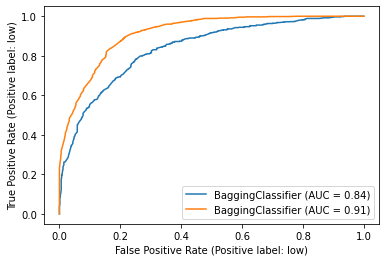

In [83]:
# comparing the ROC curves for both the log model and tree model 

#blue = log model
#orange = tree model  
classifiers = [log_bag, tree_bag]
ax = plt.gca()
for i in classifiers:
    plot_roc_curve(i, X_train, y_train, ax=ax)

- As the decision tree model has a higher AUC, this is the model that I would use to classify the high and low classes

#### #### Accuracy, AUC, precision and recall of the decision tree model

In [79]:
predictions_tree = tree_bag.predict(X_train)

In [80]:
print(accuracy_score(y_train, predictions_tree))

0.8340978593272171


- The tree model shows a high accuracy: 83% of high and low classes are correctly classified 

In [85]:
print(classification_report(y_train, predictions_tree, digits=4))

              precision    recall  f1-score   support

        high     0.8517    0.8255    0.8384       682
         low     0.8161    0.8435    0.8295       626

    accuracy                         0.8341      1308
   macro avg     0.8339    0.8345    0.8340      1308
weighted avg     0.8347    0.8341    0.8342      1308



- The precision and recall scores are higher for the decision tree compared to the log model, this further supports the decision tree model over the logistic regression model 
- the precision and recall scores for the high class are currently higher than the low class, therefore we would need to adjust this if we wanted to classify a high salary as low, instead of low as high

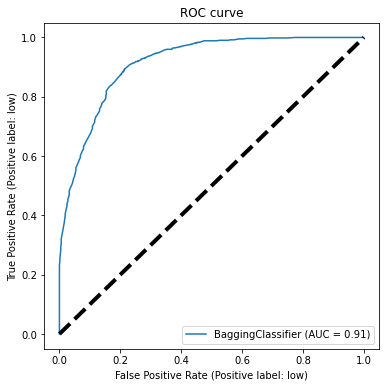

In [82]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_roc_curve(tree_bag, X_train, y_train, ax=ax)
ax.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.title('ROC curve')
plt.show()

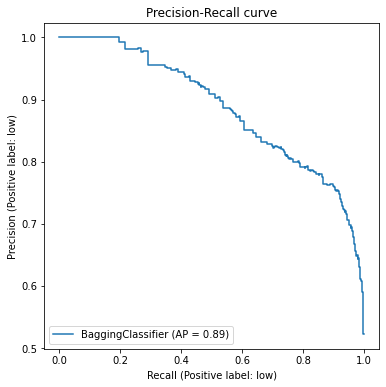

In [131]:
plt.fig, ax = plt.subplots(figsize=(6, 6))
plot_precision_recall_curve(tree_bag, X_train, y_train, ax=ax)
plt.title('Precision-Recall curve')
plt.show()

- Evaulating the above ROC and precision-recall curves of the decision tree model gives an indication of what threshold would be suitable to classify a high salary as low, rather than the other way around
- A threshold of 0.2-0.4 appears to be suitable: this would result in a higher number of false positives (ie high salaries incorrectly classified as low) but this would lead to a lower number of true negatives (high salaries correctly classified as high)
